In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import Net

from data_utils import load_train_test, load_train_test_femto
from utils import test, calc_r2_avg, model_metrics_test, test_metrics_to_results_df
from loss import RMSELoss, RMSLELoss
# from visualizations import plot_trained_model_results
from sklearn.metrics import r2_score

import h5py
from pathlib import Path

import fnmatch
import os
import shutil

from scipy.stats import pointbiserialr

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

In [229]:
# set the folder location of the temporary results
temp_dir = Path('archive/results_csv/')

In [230]:
# use multi-processing to load all the CSVs into one file
# https://stackoverflow.com/a/36590187
# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


def main(folder_path):

    # get a list of file names
    files = os.listdir(folder_path)
    file_list = [temp_dir / filename for filename in files if filename.endswith('.csv')]

    # set up your pool
    with Pool(processes=7) as pool: # or whatever your hardware can support

        # have your pool map the file names to dataframes
        df_list = pool.map(read_csv, file_list)

        # reduce the list of dataframes to a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        return combined_df
        

if __name__ == '__main__':
    df = main(temp_dir)
    
# drop first column
try:
    df = df.drop(columns='Unnamed: 0')
except:
    pass

# export combined dataframe
# csv sav_name
csv_save_name = 'combined_results_2021.04.07_1.csv'

# add a unique identifier for each model architecture
df['date_time_seed'] = df['date_time'].astype(str)+'_'+df['rnd_seed_input'].astype(str)

# get name that model checkpoint was saved under
df['model_checkpoint_name'] = df['date_time'].astype(str)+'_'+df['loss_func'] +'_'+df['rnd_seed_input'].astype(str)+'.pt'

# move 'date_time_seed' to front
# df = df[[list(df).pop()] + list(df)[:-1]]

df.to_csv(csv_save_name, index=False)
print('Final df shape:',df.shape)

#### append test results to df ####
ADD_TEST_RESULTS = True # True or False

if ADD_TEST_RESULTS == True:
    folder_path = Path('/home/tim/Documents/bearing/data/processed/FEMTO')

#     (
#         x_train,
#         y_train,
#         x_val,
#         y_val,
#         x_test,
#         y_test,
#         x_train_2,
#         y_train_2,
#         x_train_3,
#         y_train_3,
#     ) = load_train_test(folder_path)
    
    
    (
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        x_train1_1,
        y_train1_1,
        x_train2_1,
        y_train2_1,
        x_train3_1,
        y_train3_1,
        x_val1_2,
        y_val1_2,
        x_val2_2,
        y_val2_2,
        x_val3_2,
        y_val3_2,
        x_test1_3,
        y_test1_3,
        x_test2_3,
        y_test2_3,
        x_test3_3,
        y_test3_3,
    ) = load_train_test_femto(folder_path)


    # load beta, eta for Weibull CDF
    with h5py.File(folder_path / "eta_beta_r.hdf5", "r") as f:
        eta_beta_r = f["eta_beta_r"][:]

    ETA = eta_beta_r[0]
    BETA = eta_beta_r[1]

    y_train_days = torch.reshape(y_train[:, 0], (-1, 1))
    y_val_days = torch.reshape(y_val[:, 0], (-1, 1))
    y_test_days = torch.reshape(y_test[:, 0], (-1, 1))

#     y_train_days_2 = torch.reshape(y_train_2[:, 0], (-1, 1))
#     y_train_days_3 = torch.reshape(y_train_3[:, 0], (-1, 1))


    y_train = torch.reshape(y_train[:, 1], (-1, 1))
    y_val = torch.reshape(y_val[:, 1], (-1, 1))
    y_test = torch.reshape(y_test[:, 1], (-1, 1))

#     y_train_2 = torch.reshape(y_train_2[:, 1], (-1, 1))
#     y_train_3 = torch.reshape(y_train_3[:, 1], (-1, 1))
    
    model_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto/checkpoints')

    # append test results onto results dataframe
    df_results = test_metrics_to_results_df(model_folder, df, x_test, y_test)
    
    standard_losses = ['mse', 'rmse', 'rmsle']

    # apply 0 or 1 for weibull, and for each unique loss func
    for index, value in df_results['loss_func'].items():
        if value in standard_losses:
            df_results.loc[index, 'weibull_loss'] = 0
        else:
            df_results.loc[index, 'weibull_loss'] = 1

    # convert to 'weibull_loss' column to integer
    df_results['weibull_loss'] = df_results['weibull_loss'].astype(int)


    loss_func_list = df_results['loss_func'].unique()

    for index, value in df_results['loss_func'].items():
        for loss_func in loss_func_list:
            df_results.loc[index, value] = 1

    df_results[loss_func_list] = df_results[loss_func_list].fillna(0, downcast='infer')
    
    
    df_results.to_csv('combined_results_2021.04.07_1_with_test_0_1.csv', index=False)
    
clear_output(wait=True)
df.head()

date_time data_set     loss_func  rnd_seed_input  \
0  2021_04_06_18:27:11    femto           mse         6548519   
1  2021_04_06_18:27:11    femto          rmse         6548519   
2  2021_04_06_18:27:11    femto         rmsle         6548519   
3  2021_04_06_18:27:11    femto   weibull_mse         6548519   
4  2021_04_06_18:27:11    femto  weibull_rmse         6548519   

   rnd_search_iter  rnd_search_iter_no  beta       eta  epochs  patience  ...  \
0             3000                   0   2.0  0.199977    2000        50  ...   
1             3000                   0   2.0  0.199977    2000        50  ...   
2             3000                   0   2.0  0.199977    2000        50  ...   
3             3000                   0   2.0  0.199977    2000        50  ...   
4             3000                   0   2.0  0.199977    2000        50  ...   

     r2_val  r2_val_avg  r2_train1_1_avg  r2_train2_1_avg  r2_train3_1_avg  \
0  0.423273    0.706661         0.991397         0.853868         0.811558   
1  0.366218    0.687964         0.993192         0.870161         0.832088   
2  0.384049    0.670336         0.991317         0.827129         0.786095   
3  0.382486    0.697196         0.797620         0.828796         0.850091   
4  0.462939    0.756687         0.921853         0.798219         0.766192   

   r2_val1_2_avg  r2_val2_2_avg  r2_val3_2_avg               date_time_seed  \
0       0.143478       0.705320       0.588446  2021_04_06_18:27:11_6548519   
1       0.003576       0.693544       0.556011  2021_04_06_18:27:11_6548519   
2       0.078881       0.690760       0.521138  2021_04_06_18:27:11_6548519   
3       0.280522       0.773400       0.414762  2021_04_06_18:27:11_6548519   
4       0.481302       0.794010       0.458608  2021_04_06_18:27:11_6548519   

                         model_checkpoint_name  
0           2021_04_06_18:27:11_mse_6548519.pt  
1          2021_04_06_18:27:11_rmse_6548519.pt  
2         2021_04_06_18:27:11_rmsle_6548519.pt  
3   2021_04_06_18:27:11_weibull_mse_6548519.pt  
4  2021_04_06_18:27:11_weibull_rmse_6548519.pt  

[5 rows x 37 columns]

Define the metrics used to filter the results.

## Filter Results and Look at Top Performing

Filter the results by $R^2$, RMSE, and select top performing models from each batch of models. Chart.

In [228]:
# load csv
csv_save_name = 'combined_results_2021.04.07_1_with_test_0_1.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

# how many unique model architectures?
print('No. unique model architectures:', len(dfr['date_time_seed'].unique()))
print('No. unique models (includes unique loss functions):', len(dfr['date_time_seed']))


No. unique model architectures: 991
No. unique models (includes unique loss functions): 8495


In [239]:
# load csv
csv_save_name = 'combined_results_2021.04.07_1_with_test_0_1.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

print('original dfr shape:', dfr.shape)

# add filter
# tight filter
# r2_bound = 0.3 # greater than
# rmse_bound = 0.25 # less than

# looser filter
r2_bound = 0.2 # greater than
rmse_bound = 0.35 # less than

# even looser filter
# r2_bound = 0.0 # greater than
# rmse_bound = 1.0 # less than

# define what metric we'll use to evaulatate results
# sort_by = 'loss_rmse_test'
# sort_by = 'r2_val'
sort_by = 'r2_test'
# sort_by = 'r2_test_avg'

dfr = dfr[(dfr['r2_test']>r2_bound) & 
         (dfr['loss_rmse_test']<rmse_bound) &
         (dfr['r2_train']>r2_bound) &
         (dfr['loss_rmse_train']<rmse_bound) &
         (dfr['r2_val']>r2_bound) & 
         (dfr['loss_rmse_val']<rmse_bound) &
         (dfr['beta']==2.0)
][:]

print('shape of dfr before selecting top models in each architecture:', dfr.shape)

dfr = dfr.groupby(['date_time_seed']).apply(lambda x: x.sort_values([sort_by], ascending = False)).reset_index(drop=True)
dfr = dfr.groupby(['date_time_seed']).head(1).sort_values(by=sort_by, ascending=False)
# dfr = dfr.groupby(['date_time_seed', 'weibull_loss']).head(1).sort_values(by=sort_by, ascending=False)

# drop group if any models in the group did not train
# https://stackoverflow.com/a/34715183/9214620
# dfr = dfr.groupby(['date_time_seed']).filter(lambda x: x[sort_by].min() > 0.2)
dfr.to_csv('best_results_pronostia.csv', index=False)
print(dfr.shape)

original dfr shape: (8495, 52)
shape of dfr before selecting top models in each architecture: (1232, 52)
(582, 52)


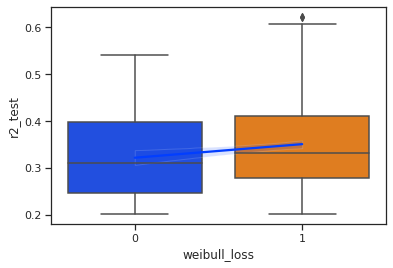

PointbiserialrResult(correlation=0.12077613125642644, pvalue=0.0035216050319884047)


In [221]:
sns.set(style="ticks",palette='bright')
ax = sns.boxplot(x=dfr['weibull_loss'], y=dfr[sort_by])
ax = sns.regplot(x=dfr['weibull_loss'], y=dfr[sort_by], scatter=False)
plt.show()

weibull_or_not = dfr['weibull_loss']
r2_test = dfr[sort_by]

pbc = pointbiserialr(weibull_or_not, r2_test)
print(pbc)

In [222]:
def change_loss_func_name(cols):
    loss_func = cols[0]
    
    if loss_func == 'mse':
        return 'MSE'
    elif loss_func == 'rmse':
        return 'RMSE'
    elif loss_func == 'rmsle':
        return 'RMSLE'
    elif loss_func == 'weibull_mse':
        return 'Weibull-MSE\nCombined'
    elif loss_func == 'weibull_rmse':
        return 'Weibull-RMSE\nCombined'
    elif loss_func == 'weibull_rmsle':
        return 'Weibull-RMSLE\nCombined'
    elif loss_func == 'weibull_only_mse':
        return 'Weibull Only MSE'
    elif loss_func == 'weibull_only_rmse':
        return 'Weibull Only RMSE'
    else:
        return 'Weibull Only RMLSE'    

df_count = dfr.groupby(['loss_func'], as_index=False).count()[['loss_func', 'date_time']].rename(columns={'date_time':'count'}).sort_values(by='count',ascending=False)
df_count['loss_func2'] = df_count[['loss_func']].apply(change_loss_func_name, axis=1)
df_count = df_count.drop('loss_func', axis=1)
df_count = df_count.rename(columns={'loss_func2':'loss_func'})
df_count['count'] = df_count['count'].astype(float)
df_count['percent'] = 100 * df_count['count'] / df_count['count'].sum()
df_count

count                loss_func    percent
3  164.0    Weibull-MSE\nCombined  28.178694
6   90.0       Weibull Only RMLSE  15.463918
5   88.0        Weibull Only RMSE  15.120275
4   58.0         Weibull Only MSE   9.965636
8   51.0  Weibull-RMSLE\nCombined   8.762887
2   41.0                    RMSLE   7.044674
0   36.0                      MSE   6.185567
1   29.0                     RMSE   4.982818
7   25.0   Weibull-RMSE\nCombined   4.295533

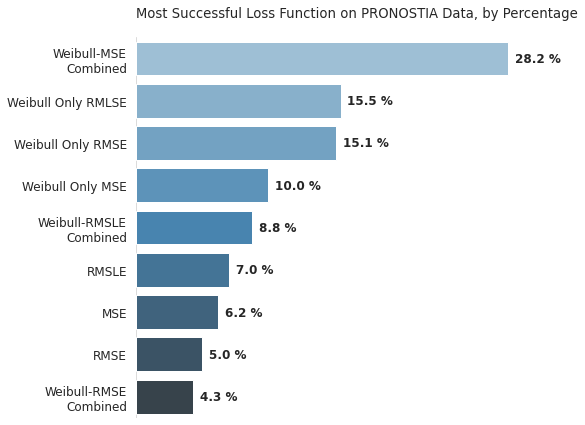

In [233]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7),)

sns.set(font_scale=1.1, style="whitegrid")
ax = sns.barplot(
    x="percent", y="loss_func", data=df_count, palette="Blues_d",
)
for p in ax.patches:
    # help from https://stackoverflow.com/a/56780852/9214620
    space = 0.5
    _x = p.get_x() + p.get_width() + float(space)
    _y = p.get_y() + p.get_height() / 2
    value = p.get_width()
    ax.text(_x, _y, f"{value:.1f} %", ha="left", va="center", weight="semibold", size=12)

ax.spines["bottom"].set_visible(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.grid(alpha=0.7, linewidth=1, axis="x")
ax.set_xticks([0])
ax.set_xticklabels([], alpha=0)
plt.title("Most Successful Loss Function on PRONOSTIA Data, by Percentage", loc="left")

sns.despine(left=True, bottom=True)
# plt.savefig('loss_func_count_femto.png',dpi=600,bbox_inches = "tight")
df_count.to_csv('pronostia_count_results.csv', index=False)
plt.show()

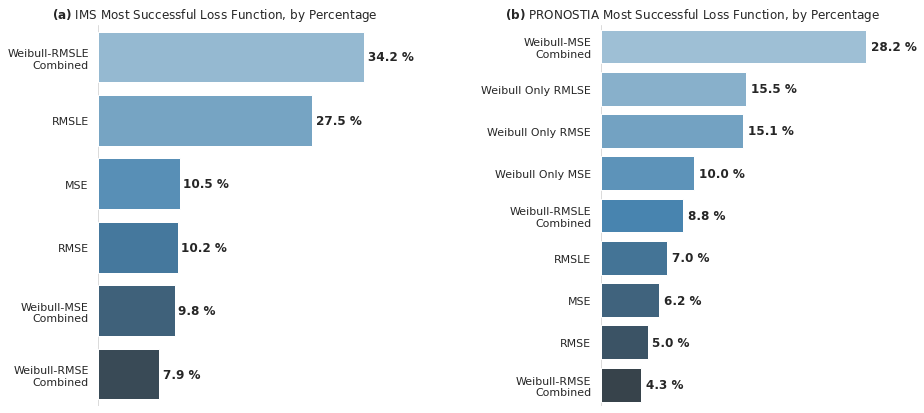

In [247]:
# chart showing both IMS and PRONOSTIA percentages
# load dataframes
ims_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims')
pron_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto')

ims_save_name = 'ims_count_results.csv'
pron_save_name = 'pronostia_count_results.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfi = pd.read_csv(ims_folder / ims_save_name)
dfp = pd.read_csv(pron_folder / pron_save_name)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7),)


title_list = [r"$\bf{(a)}$"+" IMS Most Successful Loss Function, by Percentage", 
              r"$\bf{(b)}$"+' PRONOSTIA Most Successful Loss Function, by Percentage']
df_list = [dfi, dfp]

sns.set(font_scale=1.0, style="whitegrid", font="DejaVu Sans")

for ax, df, title in zip(axes.flat, df_list, title_list):
    print()
    

    ax = sns.barplot(
        x="percent", y="loss_func", data=df, palette="Blues_d", ax=ax
    )

    for p in ax.patches:
        # help from https://stackoverflow.com/a/56780852/9214620
        space = 0.5
        _x = p.get_x() + p.get_width() + float(space)
        _y = p.get_y() + p.get_height() / 2
        value = p.get_width()
        ax.text(_x, _y, f"{value:.1f} %", ha="left", va="center", weight="semibold", size=12)

    ax.spines["bottom"].set_visible(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(alpha=0.7, linewidth=1, axis="x")
    ax.set_xticks([0])
    ax.set_xticklabels([])
#     ax.text(-0.4, 1.06, title,
#     verticalalignment='top', horizontalalignment='left',
#     transform=ax.transAxes,
#     color='black', fontsize=12)
    
    ax.set_title(title, fontsize=12, loc='right')
    

plt.subplots_adjust(wspace=0.8)
sns.despine(left=True, bottom=True)
plt.savefig('loss_function_percentages.svg',format='svg', dpi=300, bbox_inches = "tight")
plt.show()

In [224]:
# Path("temp_pics/").mkdir(parents=True, exist_ok=True)
# cwd = Path.cwd()
# temp_path = Path("temp_pics/")

# for i, row in dfr.iterrows():
#     date_time = str(row['date_time'])
#     rnd_seed_input = str(row['rnd_seed_input']) 
# #     loss_func = str(row['loss_func'])
    
#     for file in os.listdir('learning_curves/'):
# #         if fnmatch.fnmatch(file, f'{date_time}_{loss_func}_{rnd_seed_input}.png'):
#         if fnmatch.fnmatch(file, f'{date_time}*{rnd_seed_input}.png'):
# #             print(file)
            
#             shutil.copy(cwd / 'learning_curves' / file, temp_path / file)

## Filter Results and Look Correlation

In [235]:
# load csv
csv_save_name = 'combined_results_2021.04.07_1_with_test_0_1.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

# add filter
r2_bound = 0.2 # greater than
rmse_bound = 0.35 # less than

# even looser filter
# r2_bound = 0.0 # greater than
# rmse_bound = 1.0 # less than


# define what metric we'll use to evaulatate results
# sort_by = 'loss_rmse_test'
# sort_by = 'r2_val'
sort_by = 'r2_test'
# sort_by = 'r2_test_avg'


# dfr = dfr.groupby(['date_time_seed']).apply(lambda x: x.sort_values([sort_by], ascending = False)).reset_index(drop=True)
# dfr = dfr.groupby(['date_time_seed']).head(1).sort_values(by=sort_by, ascending=False)
# dfr = dfr.groupby(['date_time_seed', 'weibull_loss']).head(1).sort_values(by=sort_by, ascending=False)

dfr = dfr[(dfr['r2_test']>r2_bound) & 
         (dfr['loss_rmse_test']<rmse_bound) &
         (dfr['r2_train']>r2_bound) &
         (dfr['loss_rmse_train']<rmse_bound) &
         (dfr['r2_val']>r2_bound) & 
         (dfr['loss_rmse_val']<rmse_bound) &
         (dfr['beta']==2.0)
][:]

# drop group if any models in the group did not train
# https://stackoverflow.com/a/34715183/9214620
# dfr = dfr.groupby(['date_time_seed']).filter(lambda x: x[sort_by].min() > 0.2)
# dfr.to_csv('rmse_best_results.csv', index=False)

print(dfr.shape)

(1232, 52)


In [238]:
def change_loss_func_name(cols):
    loss_func = cols[0]
    
    if loss_func == 'mse':
        return 'MSE'
    elif loss_func == 'rmse':
        return 'RMSE'
    elif loss_func == 'rmsle':
        return 'RMSLE'
    elif loss_func == 'weibull_mse':
        return 'Weibull-MSE\nCombined'
    elif loss_func == 'weibull_rmse':
        return 'Weibull-RMSE\nCombined'
    elif loss_func == 'weibull_rmsle':
        return 'Weibull-RMSLE\nCombined'
    elif loss_func == 'weibull_only_mse':
        return 'Weibull Only\nMSE'
    elif loss_func == 'weibull_only_rmse':
        return 'Weibull Only\nRMSE'
    else:
        return 'Weibull Only\nRMLSE'    

loss_func_list = dfr['loss_func'].unique()
    
df_c = dfr[list(loss_func_list) + [sort_by]].copy()

results = {}
for i in loss_func_list:
    results[i] = list(pointbiserialr(df_c[i], df_c[sort_by]))
    
df_r = pd.DataFrame.from_dict(results).T
df_r = df_r.rename(columns={0: 'corr', 1:'p_value'}).sort_values(by='corr').sort_values(by='corr',ascending=False)
df_r['loss_func2'] = df_r.index # reset index
df_r = df_r.reset_index(drop=True)
df_r['loss_func'] = df_r[['loss_func2']].apply(change_loss_func_name, axis=1)
df_r = df_r.drop('loss_func2', axis=1)
df_r.to_csv('pronostia_correlation_results.csv', index=False)
df_r

corr       p_value                loss_func
0  0.197346  2.775707e-12      Weibull Only\nRMLSE
1  0.125986  9.194830e-06  Weibull-RMSLE\nCombined
2  0.123848  1.304108e-05       Weibull Only\nRMSE
3  0.012624  6.580168e-01                    RMSLE
4 -0.013534  6.350949e-01   Weibull-RMSE\nCombined
5 -0.071192  1.243761e-02                     RMSE
6 -0.073631  9.729005e-03                      MSE
7 -0.103686  2.668589e-04    Weibull-MSE\nCombined
8 -0.166142  4.452417e-09        Weibull Only\nMSE

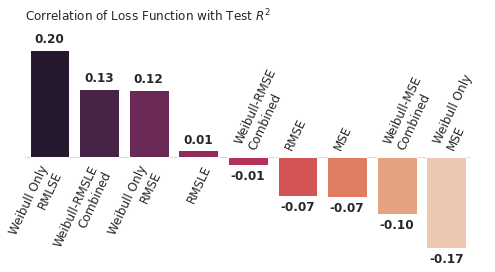

In [237]:
f, ax = plt.subplots(1,1, figsize=(8,4))
ax = sns.barplot(x='loss_func',y='corr',ax=ax, palette='rocket', data=df_r)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.axes.get_yaxis().set_visible(False) # hide y-axis
ax.grid(alpha=0.7, linewidth=1, axis="y")
ax.xaxis.set_label_text("",  size='large', weight='semibold')
ax.yaxis.set_label_text("", size='large', weight='semibold')
ax.set_yticks([0])
ax.set_yticklabels([], alpha=0)
ax.set_xticklabels([], alpha=0)
# plt.rc('xtick', labelsize='medium') 
# plt.rc('font', weight='semibold') 

for i, p in enumerate(ax.patches):
    # help from https://stackoverflow.com/a/56780852/9214620
    space = np.absolute(df_r['corr'].max()*0.1)

    value = p.get_height()
    if value >=0:
        _y = p.get_y() + p.get_height() + float(space)
        _x = p.get_x() + p.get_width() / 2
        ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=12)
#         ax.text(_x, -space, df_r['loss_func'][i], ha="center", va="top", weight="normal",multialignment='right', size=12, 
#                 rotation='vertical'
#                )
        ax.text(_x+0.3, -0.01, df_r['loss_func'][i], ha="right", va="top", weight="normal",multialignment='right', size=12, 
                rotation=65
               )

    else:
        _y = p.get_y() + p.get_height() - float(space)
        _x = p.get_x() + p.get_width() / 2
        ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=12)
        ax.text(_x-0.3, 0.01, df_r['loss_func'][i], ha="left", va="bottom", weight="normal",multialignment='left', size=12, 
                rotation=65
               )


plt.rcParams['axes.titlepad'] = 20
plt.title("Correlation of Loss Function with Test $R^2$", loc="left")
# plt.xlim(0,1)
# plt.ylim(-0.5,3.5)
# plt.savefig('date_drop.png',dpi=600, bbox_inches = "tight")

plt.show()

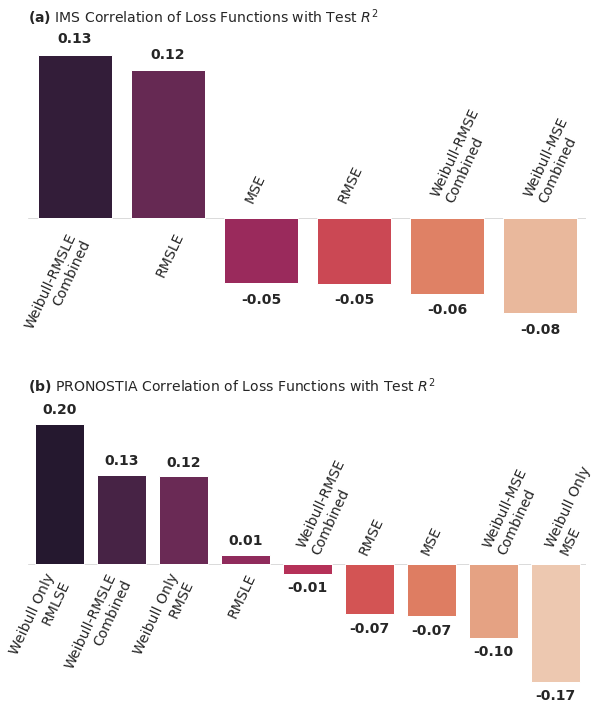

In [248]:
# chart showing both IMS and PRONOSTIA percentages
# load dataframes
ims_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims')
pron_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto')

ims_save_name = 'ims_correlation_results.csv'
pron_save_name = 'pronostia_correlation_results.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfi = pd.read_csv(ims_folder / ims_save_name)
dfp = pd.read_csv(pron_folder / pron_save_name)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12),)
sns.set(font_scale=1.1, style="whitegrid")

title_list = [r"$\bf{(a)}$"+" IMS Correlation of Loss Functions with Test $R^2$", 
              r"$\bf{(b)}$"+" PRONOSTIA Correlation of Loss Functions with Test $R^2$"]

df_list = [dfi, dfp]

for ax, df, title in zip(axes.flat, df_list, title_list):

    df = df.dropna(axis=0)
    
    ax = sns.barplot(x='loss_func',y='corr',ax=ax, palette='rocket', data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.axes.get_yaxis().set_visible(False) # hide y-axis
    ax.grid(alpha=0.7, linewidth=1, axis="y")
    ax.xaxis.set_label_text("",  size='large', weight='semibold')
    ax.yaxis.set_label_text("", size='large', weight='semibold')
    ax.set_yticks([0])
    ax.set_yticklabels([], alpha=0)
    ax.set_xticklabels([], alpha=0)
    # plt.rc('xtick', labelsize='medium') 
    # plt.rc('font', weight='semibold') 

    for i, p in enumerate(ax.patches):
        # help from https://stackoverflow.com/a/56780852/9214620
        space = np.absolute(df['corr'].max()*0.1)

        value = p.get_height()
        if value >=0:
            _y = p.get_y() + p.get_height() + float(space)
            _x = p.get_x() + p.get_width() / 2
            ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
    #         ax.text(_x, -space, df_r['loss_func'][i], ha="center", va="top", weight="normal",multialignment='right', size=12, 
    #                 rotation='vertical'
    #                )
            ax.text(_x+0.2, -0.01, df['loss_func'][i], ha="right", va="top", weight="normal",multialignment='right', size=14, 
                    rotation=65
                   )

        else:
            _y = p.get_y() + p.get_height() - float(space)
            _x = p.get_x() + p.get_width() / 2
            ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
            ax.text(_x-0.2, 0.01, df['loss_func'][i], ha="left", va="bottom", weight="normal",multialignment='left', size=14, 
                    rotation=65
                   )


    plt.rcParams['axes.titlepad'] = 20
    ax.set_title(title, loc="left", size=14)

plt.subplots_adjust(hspace=0.3)
plt.savefig('correlations.svg',dpi=300, format='svg', bbox_inches = "tight")
plt.show()

## Load Best Model and Check Test

In [242]:
folder_path = Path('/home/tim/Documents/bearing/data/processed/FEMTO')

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train1_1,
    y_train1_1,
    x_train2_1,
    y_train2_1,
    x_train3_1,
    y_train3_1,
    x_val1_2,
    y_val1_2,
    x_val2_2,
    y_val2_2,
    x_val3_2,
    y_val3_2,
    x_test1_3,
    y_test1_3,
    x_test2_3,
    y_test2_3,
    x_test3_3,
    y_test3_3,
) = load_train_test_femto(folder_path)


# load beta, eta for Weibull CDF
with h5py.File(folder_path / "eta_beta_r.hdf5", "r") as f:
    eta_beta_r = f["eta_beta_r"][:]

ETA = eta_beta_r[0]
BETA = eta_beta_r[1]

y_train1_1_days = torch.reshape(y_train1_1[:, 0], (-1, 1))
y_train2_1_days = torch.reshape(y_train2_1[:, 0], (-1, 1))
y_train3_1_days = torch.reshape(y_train3_1[:, 0], (-1, 1))
y_val1_2_days = torch.reshape(y_val1_2[:, 0], (-1, 1))
y_val2_2_days = torch.reshape(y_val2_2[:, 0], (-1, 1))
y_val3_2_days = torch.reshape(y_val3_2[:, 0], (-1, 1))
y_test1_3_days = torch.reshape(y_test1_3[:, 0], (-1, 1))
y_test2_3_days = torch.reshape(y_test2_3[:, 0], (-1, 1))
y_test3_3_days = torch.reshape(y_test3_3[:, 0], (-1, 1))


y_train = torch.reshape(y_train[:, 1], (-1, 1))
y_val = torch.reshape(y_val[:, 1], (-1, 1))
y_test = torch.reshape(y_test[:, 1], (-1, 1))

y_train1_1 = torch.reshape(y_train1_1[:, 1], (-1, 1)) 
y_train2_1 = torch.reshape(y_train2_1[:, 1], (-1, 1))
y_train3_1 = torch.reshape(y_train3_1[:, 1], (-1, 1))
y_val1_2 = torch.reshape(y_val1_2[:, 1], (-1, 1))
y_val2_2 = torch.reshape(y_val2_2[:, 1], (-1, 1))
y_val3_2 = torch.reshape(y_val3_2[:, 1], (-1, 1))
y_test1_3 = torch.reshape(y_test1_3[:, 1], (-1, 1))
y_test2_3 = torch.reshape(y_test2_3[:, 1], (-1, 1))
y_test3_3 = torch.reshape(y_test3_3[:, 1], (-1, 1))


In [243]:
y_train1_1_days[:12]*24

tensor([[0.0000],
        [0.0145],
        [0.0173],
        [0.0201],
        [0.0228],
        [0.0256],
        [0.0284],
        [0.0312],
        [0.0339],
        [0.0367],
        [0.0395],
        [0.0423]])

In [244]:
# load best results csv so that we can get the best model
df_best = pd.read_csv('best_results_pronostia.csv')

# should already be sorted, but make sure
df_best = df_best.sort_values(by='r2_test',ascending=False)

# seclect top performing model and get the name it was saved under
model_name = df_best['model_checkpoint_name'][0]
print(model_name)

model_path = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto/checkpoints') / model_name

# select device to run neural net on
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")
    
criterion_mae = nn.L1Loss()
criterion_rmse = RMSELoss()
criterion_rmsle = RMSLELoss()

net = torch.load(model_path, map_location=device)

2021_04_06_21:34:43_weibull_only_rmsle_5018061.pt
Running on CPU


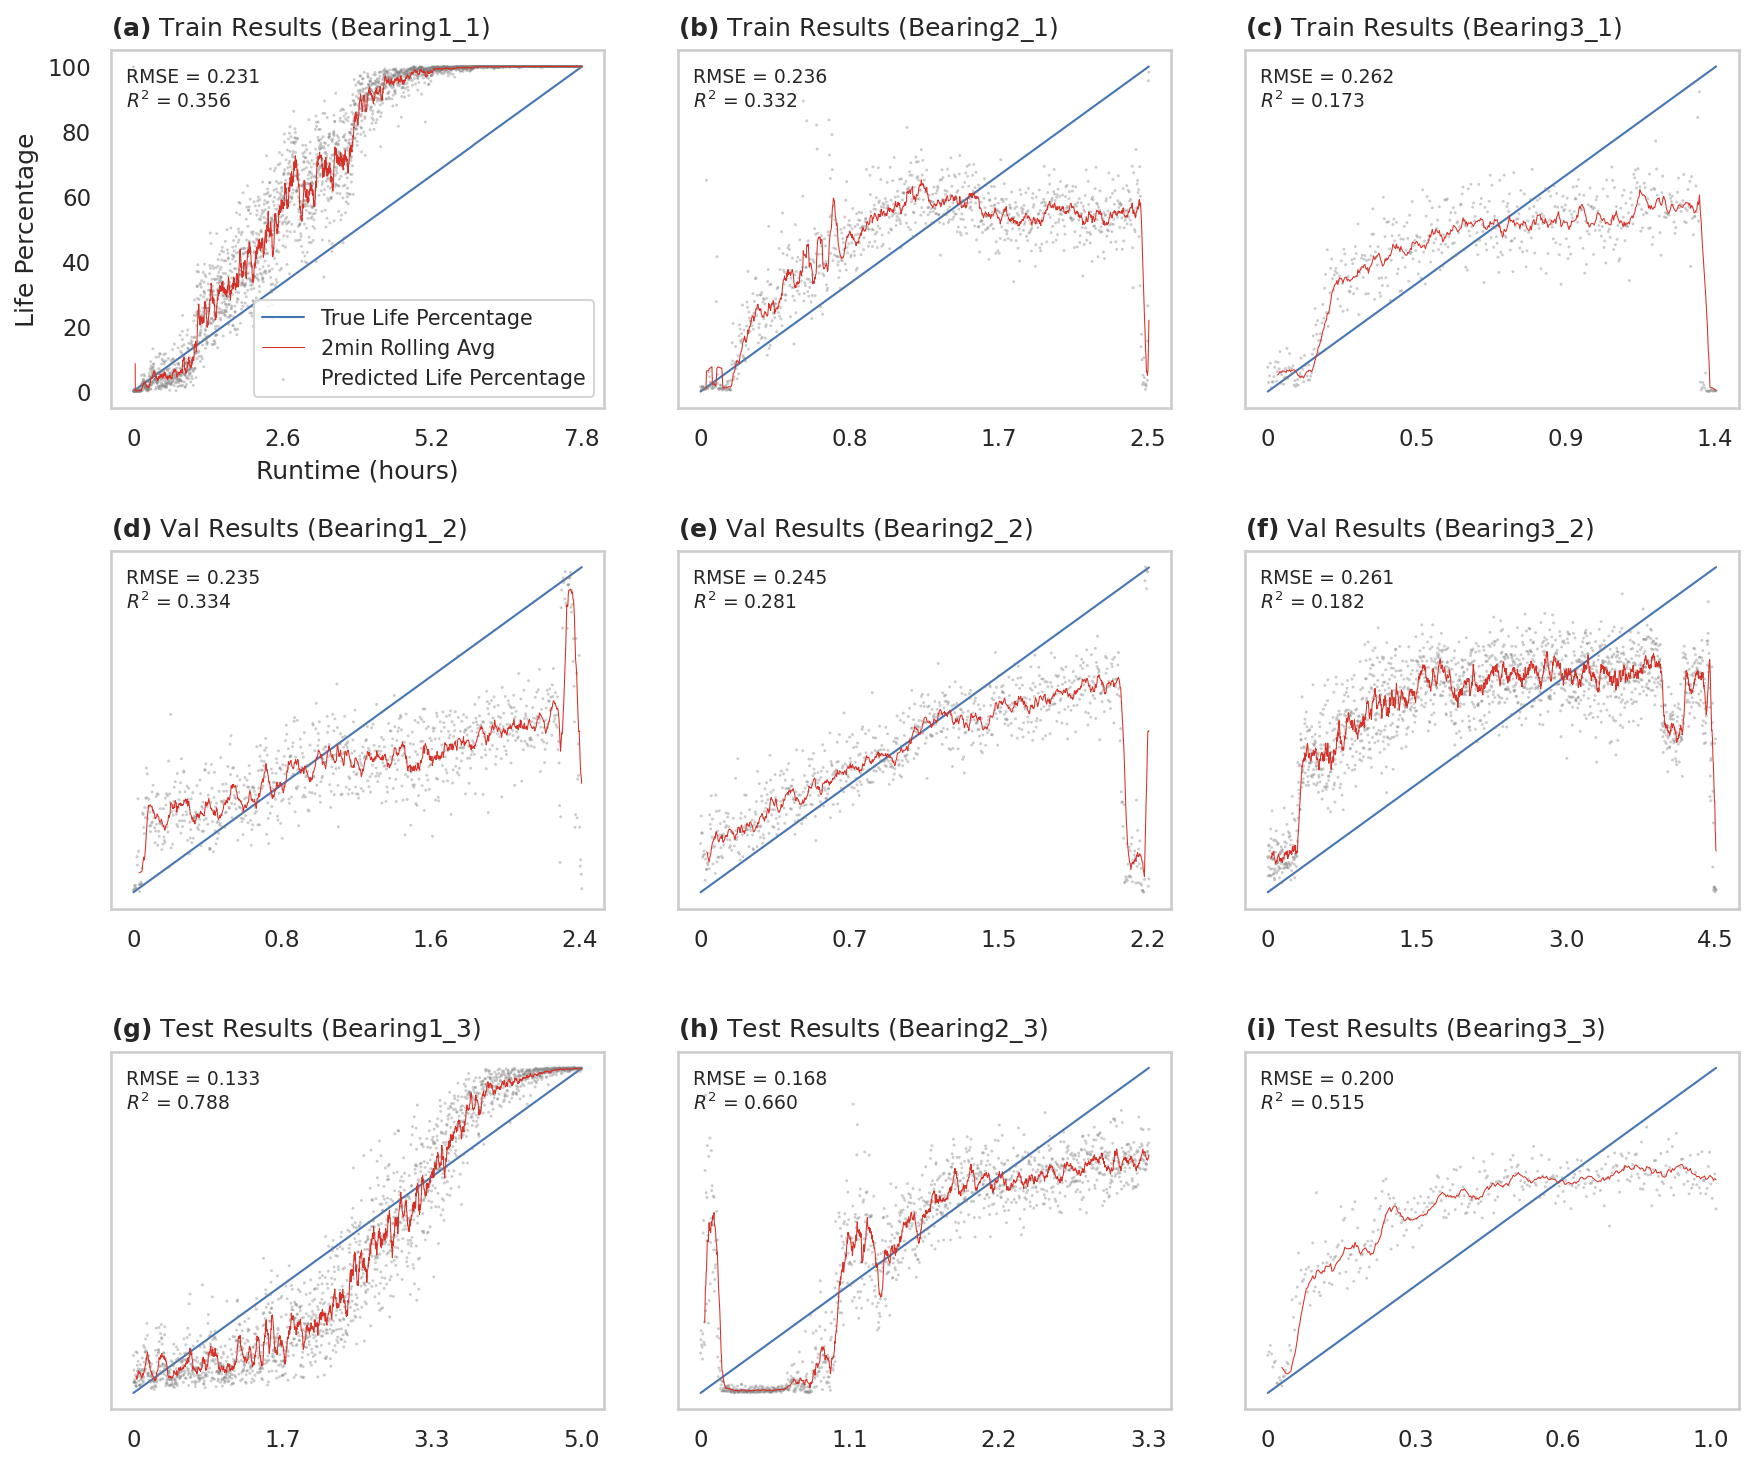

In [250]:
from matplotlib import gridspec
# from matplotlib import rc
# rc('text', usetex=True)


def calc_r2_avg(y_hats, y_val, index_sorted, window_size):
    y_hats_rolling_avg = np.convolve(np.array(y_hats[index_sorted]).reshape(-1), np.ones(window_size), 'valid') / window_size
    r2_val_avg = r2_score(np.array(y_val)[index_sorted][window_size-1:], y_hats_rolling_avg)
    return r2_val_avg, y_hats_rolling_avg

# y_list
y_list = [y_train1_1, y_train2_1, y_train3_1, 
          y_val1_2, y_val2_2, y_val3_2, 
          y_test1_3, y_test2_3, y_test3_3]

# x_list
x_list = [x_train1_1, x_train2_1, x_train3_1, 
          x_val1_2, x_val2_2, x_val3_2, 
          x_test1_3, x_test2_3, x_test3_3,]

# y_days_list
y_days_list = [y_train1_1_days, y_train2_1_days, y_train3_1_days, 
               y_val1_2_days, y_val2_2_days, y_val3_2_days, 
               y_test1_3_days, y_test2_3_days, y_test3_3_days]

ax_title_list = [r"$\bf{(a)}$"+" Train Results (Bearing1_1)", 
                 r"$\bf{(b)}$"+" Train Results (Bearing2_1)", 
                 r"$\bf{(c)}$"+" Train Results (Bearing3_1)",
                 r"$\bf{(d)}$"+" Val Results (Bearing1_2)", 
                 r"$\bf{(e)}$"+" Val Results (Bearing2_2)", 
                 r"$\bf{(f)}$"+" Val Results (Bearing3_2)",
                 r"$\bf{(g)}$"+" Test Results (Bearing1_3)", 
                 r"$\bf{(h)}$"+" Test Results (Bearing2_3)", 
                 r"$\bf{(i)}$"+" Test Results (Bearing3_3)"]



###### CREATE FIGURE #####
# color blind colors, from https://bit.ly/3qJ6LYL
# [#d73027, #fc8d59, #fee090, #4575b4]
# [redish, orangeish, yellowish, blueish]

sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(14, 12), dpi=150) 
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax7 = plt.subplot(gs[2, 0])
ax8 = plt.subplot(gs[2, 1])
ax9 = plt.subplot(gs[2, 2])
gs.update(wspace = 0.15, hspace = 0.4)


## General Formatting ##
# create list of axis elements
axes_list = [ax1, ax2, ax3, 
             ax4, ax5, ax6, 
             ax7, ax8, ax9]

for ax in axes_list:
    ax.grid(b=None)

plt.rcParams['axes.titlepad'] = 7    
    
###### TEST DATA #####
net.eval()

counter = 0
for ax, y_temp, x_temp, y_days, ax_title in zip(axes_list, y_list,
                            x_list, y_days_list, ax_title_list):
    
    y_hats = test(net, x_temp, device, 100)
    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))

    # build rolling average
    window_size = 12 # 2 minute rolling avg
    r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_temp, index_sorted, window_size)

    loss_rmse_test = criterion_rmse(y_hats, y_temp)
    r2_test = r2_score(y_temp, y_hats)

    ax.plot(np.array(y_temp)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=1, zorder=0)
    ax.scatter(
        np.arange(0, len(y_hats), 1),
        y_hats[index_sorted]*100,
        label="Predicted Life Percentage",
        alpha=0.4,
        c="grey", edgecolors='none',
        s=2,
    )

    ax.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
            color='#d73027', alpha=1, label=f'{int(window_size/6)}min Rolling Avg', linewidth=0.5)

    print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=9,
        fontweight="normal",
        verticalalignment="top",
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

    index_new = np.arange(0,len(y_hats),int(len(y_hats)/3)-1)

    y_days_temp = np.array(y_days)
    y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

    labels_new = [f'{i*24:.1f}' for i in y_days_temp[index_new]]
    # change first value to '0'
    labels_new[0] = '0'

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
    ax.set_title(ax_title, loc="left")
    
    if counter == 0:
        ax.set_xlabel("Runtime (hours)")
        ax.set_ylabel("Life Percentage")
        ax.legend(loc='lower right', fontsize=10)
        
    if counter !=0:
        ax.set_yticklabels([])
    
    counter += 1
    
# plt.savefig('femto_result_plot.pdf',dpi=300, bbox_inches = "tight")
# plt.savefig('femto_result_plot.png',dpi=300, format='png', bbox_inches = "tight")
plt.savefig('femto_result_plot.svg',dpi=300, format='svg', bbox_inches = "tight")
plt.show()

## Plot All Spectrograms Together


In [89]:
from scipy import signal, fftpack
import time
import datetime
import csv
import fnmatch
from typing import Tuple

def build_spectrogram_df_femto(
    folder,
    date_dict,
    channel_name="acc_horz",
    col_day_increment=False,
    col_names=["hr", "min", "sec", "micro_sec", "acc_horz", "acc_vert"],
):
    """function that builds the spectrogram data"""

    # date_time list
    date_list = sorted(list(date_dict.keys()))
    start_time = date_list[0]  # get the star time

    # instantiate dataframe for the spectrogram
    dft = pd.DataFrame()

    # dictionary to store any labels
    labels_dict = {}

    # iterate through each date that samples were taken
    # date_list should be sorted from earliest to latest
    for i, unix_timestamp in enumerate(date_list):
        # convert sample_name to unix timestamp
        date_nice_format = date_dict[unix_timestamp][1]

        # open the file containing the measurements
        df = pd.read_csv(folder / date_dict[unix_timestamp][2], names=col_names)

        # create fft
        xf, yf = create_fft(
            df,
            x_name="Time",
            y_name=channel_name,
            sample_freq=25600.0,
            show_plot=False,
            window="kaiser",
            beta=3,
        )
        # xf, yf = create_fft(df, x_name='Time', y_name=channel_name, sample_freq=20000.0, show_plot=False, window='kaiser', beta=3)

        # append the time increments
        time_increment_seconds = unix_timestamp - start_time
        time_increment_days = time_increment_seconds / (60 * 60 * 24)

        # create new column for the current sample_name FFT
        if col_day_increment == False:
            dft[date_nice_format] = yf
        if col_day_increment == True:
            dft[str(time_increment_days)] = yf

        # create new dictionary key and values to store lable info
        labels_dict[unix_timestamp] = [
            date_nice_format,
            unix_timestamp,
            time_increment_seconds,
            time_increment_days,
        ]

    dft = dft.set_index(xf, drop=True)  # index as frequency (Hz)
    return dft, labels_dict

def create_date_dict(folder):
    # instantiate the date dictionary that will
    # hold the date/time that each signal was recorded on
    # along with the file name

    date_dict = {}

    for i, file in enumerate(os.listdir(folder)):
        if fnmatch.fnmatch(file, f"acc*.csv"):

            # get the unix timestamp for when the file was modified (http://bit.ly/2RW5cYo)
            date_created = datetime.datetime.fromtimestamp(
                os.path.getmtime(folder / str(file))
            )

            # open each csv file, read first line, and extract times
            with open(folder / file, newline="") as f:
                csv_reader = csv.reader(f)
                csv_headings = next(csv_reader)

            # help with datetime: https://realpython.com/python-datetime/
            # convert "time" string to datetime object
            time_created = datetime.time(
                hour=int(float(csv_headings[0])),
                minute=int(float(csv_headings[1])),
                second=int(float(csv_headings[2])),
                microsecond=int(float(csv_headings[3])),
            )

            # combine date and time into a single datetime object
            combined_date = datetime.datetime.combine(date_created, time_created)
            unix_timestamp = combined_date.timestamp()
            date_nice_format = combined_date.strftime("%Y-%m-%d %H:%M:%S")

            date_dict[unix_timestamp] = [combined_date, date_nice_format, file]
    return date_dict

def create_fft(
    df: pd.DataFrame,
    x_name="Time",
    y_name: str = "b2_ch3",
    sample_freq=20480.0,
    show_plot=True,
    window="hamming",
    beta=8,
) -> Tuple[np.array, np.array]:
    """Create FFT plot from a pandas dataframe"""

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = np.arange(0, df.shape[0], dtype="float64") / (sample_freq)

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points

    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal

    if window == "hamming":
        y_detrend *= np.hamming(
            N
        )  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2) / 2

    if show_plot:
        # setup the seaborn plot
        sns.set(font_scale=1.0, style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
        fig.tight_layout(pad=5.0)

        pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

        # plot time domain signal
        axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
        axes[0].set_xlabel("Time (seconds)")
        axes[0].set_ylabel("Acceleration, g")
        # axes[0].set_yticklabels([])

        # plot the frequency domain signal
        axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Acceleration, g")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

        # clean up the sub-plots to make everything pretty
        for ax in axes.flatten():
            ax.yaxis.set_tick_params(labelleft=True, which="major")
            ax.grid(False)

        # in case you want to save the figure (just uncomment)
        # plt.savefig('time_freq_domains.svg',dpi=600,bbox_inches = "tight")
        plt.show()

    return xf, yf

In [158]:
folder_raw_data = Path('/home/tim/Documents/bearing/data/raw/FEMTO/Training_set/Learning_set')
folder_raw_data_test = Path('/home/tim/Documents/bearing/data/raw/FEMTO/Test_set/Test_set')

# Constants
RUL_OR_PERCENT = "percent"
BUCKET_SIZE = 64
RANDOM_STATE = 694
color_scheme='inferno'

folder_data_list = [folder_raw_data / "Bearing1_1", 
                    folder_raw_data / "Bearing2_1", 
                    folder_raw_data / "Bearing3_1",
                    folder_raw_data / "Bearing1_2", 
                    folder_raw_data / "Bearing2_2", 
                    folder_raw_data / "Bearing3_2",
                    folder_raw_data_test / "Bearing1_3", 
                    folder_raw_data_test / "Bearing2_3", 
                    folder_raw_data_test / "Bearing3_3"]



ax_title_list = ["(a)"+" Train, Bearing1_1", 
                 "(b)"+" Train, Bearing2_1", 
                 "(c)"+" Train, Bearing3_1",
                 "(d)"+" Val, Bearing1_2", 
                 "(e)"+" Val, Bearing2_2", 
                 "(f)"+" Val, Bearing3_2",
                 "(g)"+" Test, Bearing1_3", 
                 "(h)"+" Test, Bearing2_3", 
                 "(i)"+" Test, Bearing3_3"]

val_max_list = [0.3, 0.4, 0.3, 
                0.5, 0.4, 0.4, 
                0.6, 0.8, 0.93]

val_max_list = [0.5]*9

<ipython-input-159-355dcad69e86>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["",1000,2000,3000,4000,5000,6000])


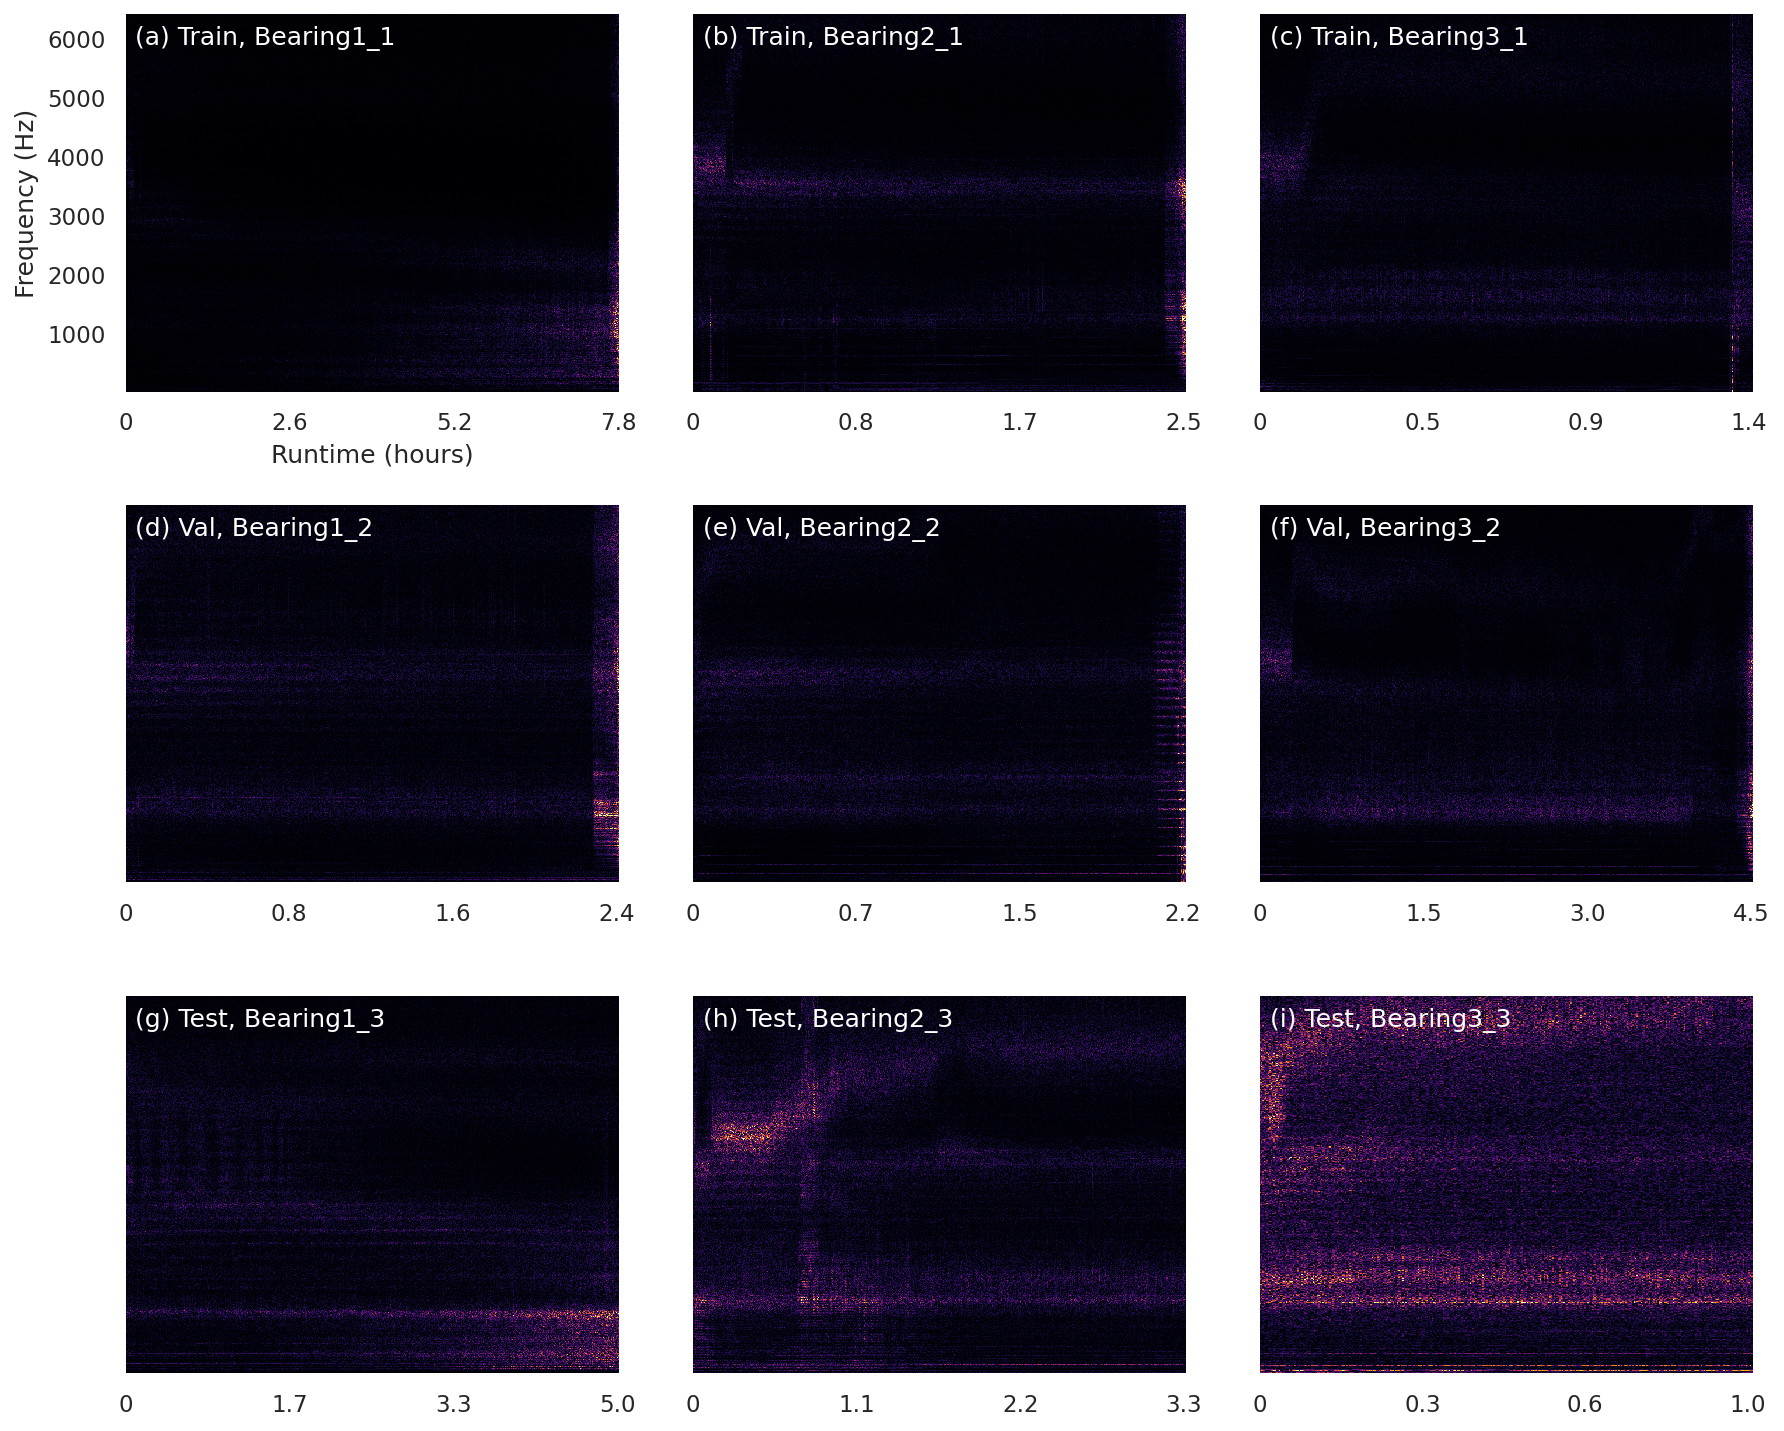

In [159]:
###### CREATE FIGURE #####
# color blind colors, from https://bit.ly/3qJ6LYL
# [#d73027, #fc8d59, #fee090, #4575b4]
# [redish, orangeish, yellowish, blueish]

sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(14, 12), dpi=150) 
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax7 = plt.subplot(gs[2, 0])
ax8 = plt.subplot(gs[2, 1])
ax9 = plt.subplot(gs[2, 2])
gs.update(wspace = 0.15, hspace = 0.3)

# create list of axis elements
axes_list = [ax1, ax2, ax3, 
             ax4, ax5, ax6, 
             ax7, ax8, ax9]

counter = 0
for ax, folder, ax_title, val_max_mod in zip(axes_list, folder_data_list, ax_title_list, val_max_list):
    date_dict = create_date_dict(folder)
    df_spec, labels_dict = build_spectrogram_df_femto(
    folder, date_dict, channel_name="acc_horz",)
    
    vmax_val = np.max(np.max(df_spec))*val_max_mod

    # create the time list that we'll use to label x-axis of spectrogram
    time_list = []

    for k in labels_dict:
        time_list.append(labels_dict[k][-1])

    time_list = np.array(sorted(time_list))
    
    index_new = np.arange(0,len(time_list),int(len(time_list)/3)-1)
    
    labels_new = [f'{i*24:.1f}' for i in time_list[index_new]]
    # change first value to '0'
    labels_new[0] = '0'
    
    ax.pcolormesh(df_spec, 
                cmap=color_scheme,
                 vmax=vmax_val,
              )
    
    
    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
#     ax.set_title(ax_title, loc="left")
    
    ax.text(0.02, 0.97, ax_title,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='white', fontsize=12)
    
    if counter == 0:
        ax.set_yticklabels(["",1000,2000,3000,4000,5000,6000])
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel('Runtime (hours)')
    else:
        ax.set_yticklabels([])
        
#     if counter !=0:
#         ax.set_yticklabels([])
    
    
    
    counter += 1
    

    
sns.despine(left=True, bottom=True, right=True)
# plt.savefig('spectrogram_all_0.5.png',format='png', dpi=300, bbox_inches = "tight")
plt.show()

In [213]:
# y_list
y_list = [y_train1_1, y_train2_1, y_train3_1, 
          y_val1_2, y_val2_2, y_val3_2, 
          y_test1_3, y_test2_3, y_test3_3]

# x_list
x_list = [x_train1_1, x_train2_1, x_train3_1, 
          x_val1_2, x_val2_2, x_val3_2, 
          x_test1_3, x_test2_3, x_test3_3,]

# y_days_list
y_days_list = [y_train1_1_days, y_train2_1_days, y_train3_1_days, 
               y_val1_2_days, y_val2_2_days, y_val3_2_days, 
               y_test1_3_days, y_test2_3_days, y_test3_3_days]

ax_title_list = ["(a)"+" Train Data (Bearing1_1)", 
                 "(b)"+" Train Data (Bearing2_1)", 
                 "(c)"+" Train Data (Bearing3_1)",
                 "(d)"+" Val Data (Bearing1_2)", 
                 "(e)"+" Val Data (Bearing2_2)", 
                 "(f)"+" Val Data (Bearing3_2)",
                 "(g)"+" Test Data (Bearing1_3)", 
                 "(h)"+" Test Data (Bearing2_3)", 
                 "(i)"+" Test Data (Bearing3_3)"]

val_max_list = [0.3, 0.4, 0.3, 
                0.5, 0.4, 0.4, 
                0.6, 0.8, 0.93]

# vmax_x = 0
# for x in x_list:
#     print(torch.max(x).item())

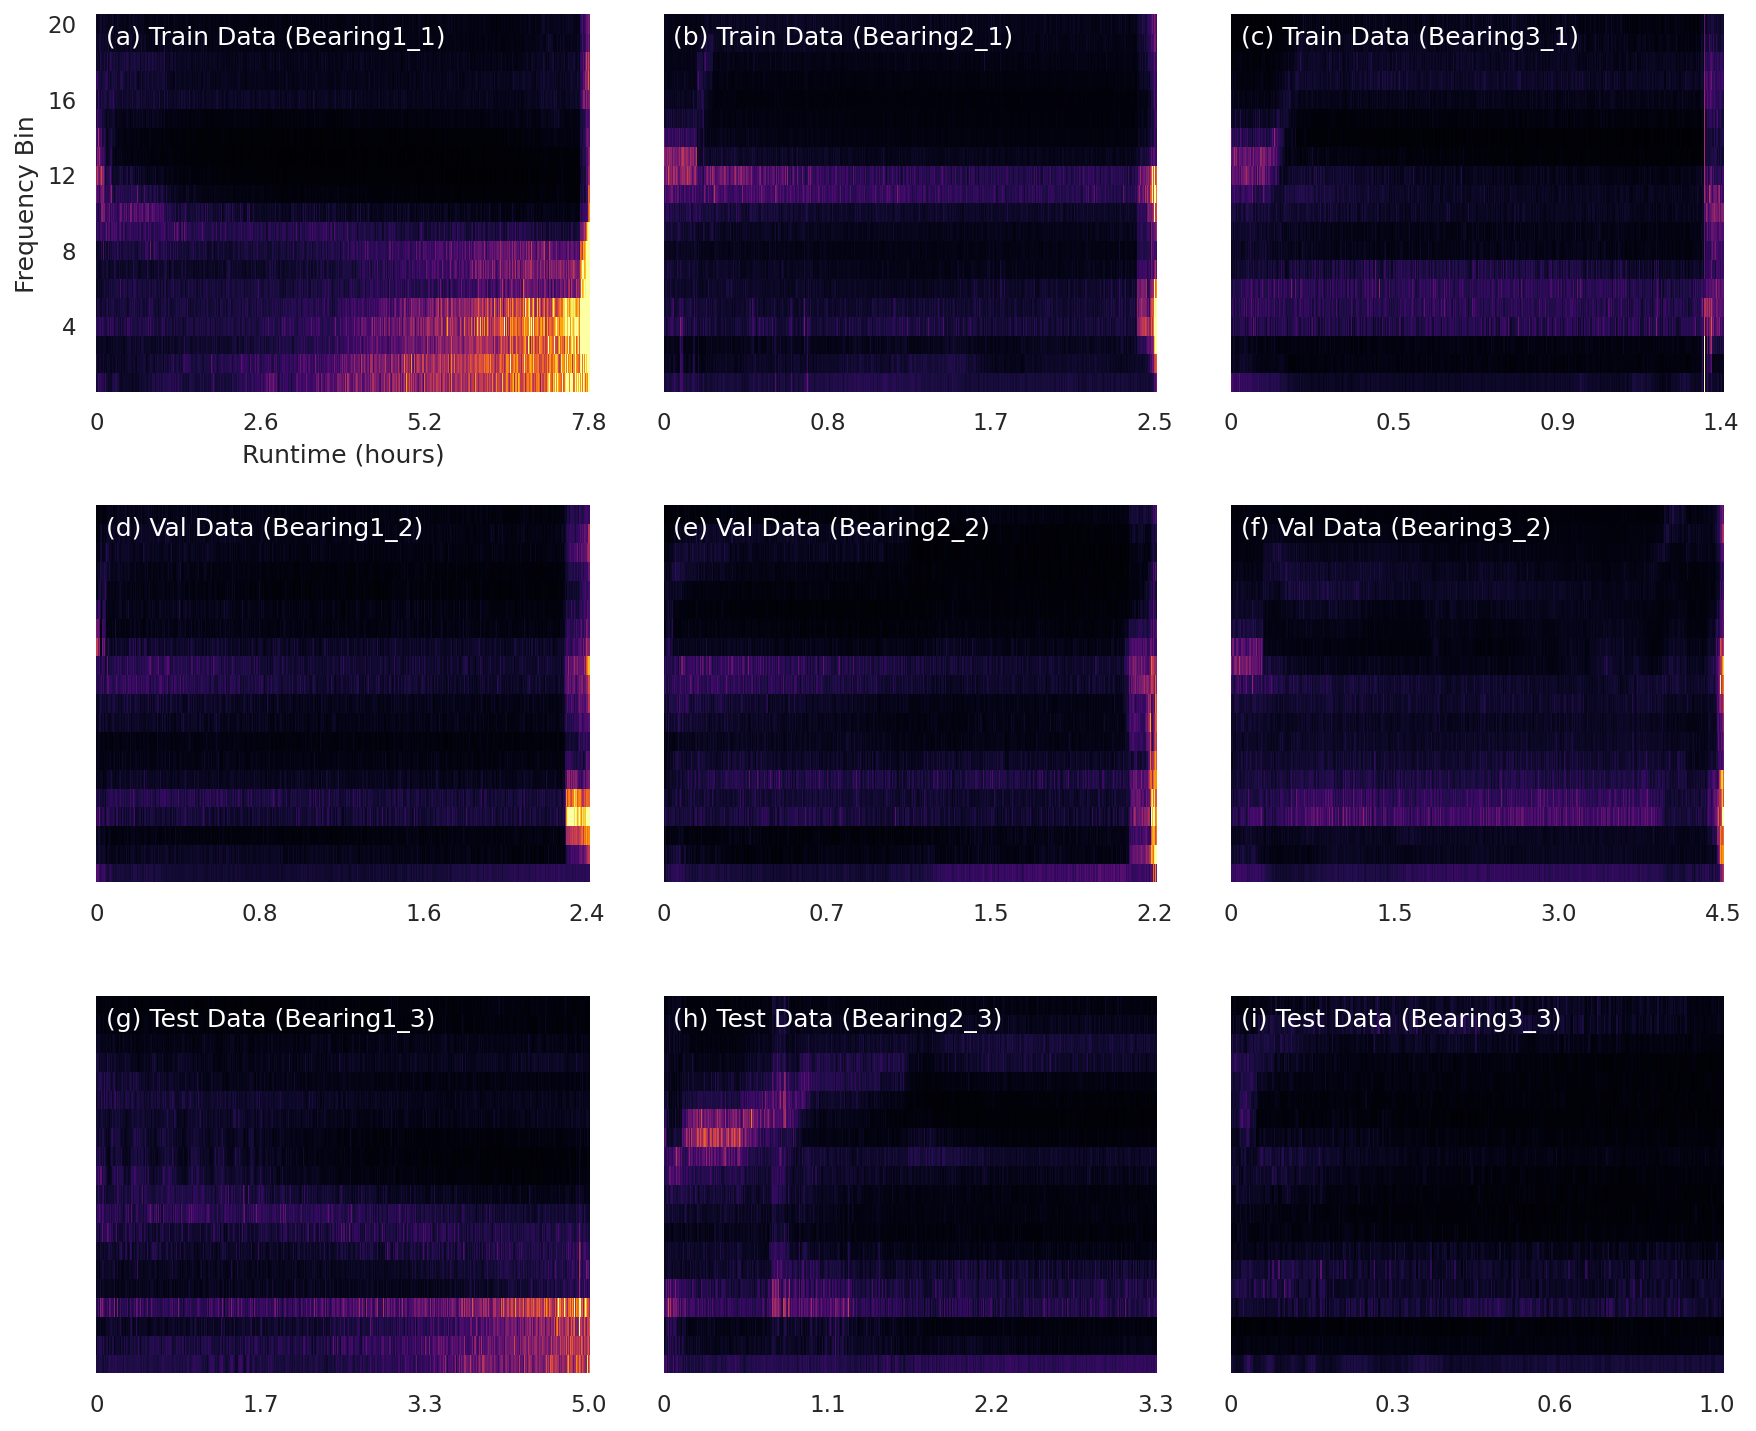

In [216]:
sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(14, 12), dpi=150) 
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax7 = plt.subplot(gs[2, 0])
ax8 = plt.subplot(gs[2, 1])
ax9 = plt.subplot(gs[2, 2])
gs.update(wspace = 0.15, hspace = 0.3)

# create list of axis elements
axes_list = [ax1, ax2, ax3, 
             ax4, ax5, ax6, 
             ax7, ax8, ax9]

counter = 0
for ax, ax_title, y_temp, x_temp, y_days in zip(axes_list, ax_title_list, y_list, x_list, y_days_list):

    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))
    
#     vmax_val = np.max(np.max(df_spec))*val_max_mod
    # create the time list that we'll use to label x-axis of spectrogram
#     time_list = []

#     for k in labels_dict:
#         time_list.append(labels_dict[k][-1])

    time_array = np.sort(y_days[:,-1])
    
    index_new = np.arange(0,len(time_array),int(len(time_array)/3)-1)
    
    labels_new = [f'{i*24:.1f}' for i in time_array[index_new]]
    # change first value to '0'
    labels_new[0] = '0'
    
    ax.pcolormesh(x_temp[index_sorted].T, 
                cmap=color_scheme,
                 vmax=0.2,
              )

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
    
    ax.text(0.02, 0.97, ax_title,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='white', fontsize=12)
    
    if counter == 0:
        ax.set_xticks(index_new)
        ax.set_xticklabels(labels_new,)
        ax.set_yticks(np.arange(3.5,20.5,4))
        ax.set_yticklabels(list(np.arange(4,21,4)))
        ax.set_ylabel('Frequency Bin')
        ax.set_xlabel('Runtime (hours)')
    else:
        ax.set_yticklabels([])
        
    if counter !=0:
        ax.set_yticklabels([])
    
    
    
    counter += 1
    

    
sns.despine(left=True, bottom=True, right=True)
plt.savefig('spectrogram_processed_data_femto.png',format='png', dpi=300, bbox_inches = "tight")
plt.show()

In [183]:
index_new

array([   0,  932, 1864, 2796])

In [ ]:
    y_hats = test(net, x_temp, device, 100)
    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))

    # build rolling average
    window_size = 12 # 2 minute rolling avg
    r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_temp, index_sorted, window_size)

    loss_rmse_test = criterion_rmse(y_hats, y_temp)
    r2_test = r2_score(y_temp, y_hats)

    ax.plot(np.array(y_temp)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=1, zorder=0)
    ax.scatter(
        np.arange(0, len(y_hats), 1),
        y_hats[index_sorted]*100,
        label="Predicted Life Percentage",
        alpha=0.4,
        c="grey", edgecolors='none',
        s=2,
    )

    ax.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
            color='#d73027', alpha=1, label=f'{int(window_size/6)}min Rolling Avg', linewidth=0.5)

    print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=9,
        fontweight="normal",
        verticalalignment="top",
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

    index_new = np.arange(0,len(y_hats),int(len(y_hats)/3)-1)

    y_days_temp = np.array(y_days)
    y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

    labels_new = [f'{i*24:.1f}' for i in y_days_temp[index_new]]
    # change first value to '0'
    labels_new[0] = '0'

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
    ax.set_title(ax_title, loc="left")
    
    if counter == 0:
        ax.set_xlabel("Hours")
        ax.set_ylabel("Life Percentage")
        ax.legend(loc='lower right', fontsize=10)
        
    if counter !=0:
        ax.set_yticklabels([])
    
    counter += 1
    

In [111]:
folder_indv_bearing = folder_raw_data / "Bearing1_1"
date_dict = create_date_dict(folder_indv_bearing)
df_spec, labels_dict = build_spectrogram_df_femto(
    folder_indv_bearing, date_dict, channel_name="acc_horz",
)

# create the time list that we'll use to label x-axis of spectrogram
time_list = []

for k in labels_dict:
    time_list.append(labels_dict[k][-1])

time_list = np.array(sorted(time_list))

labels_new = [f'{i*24:.1f}' for i in time_list]
# change first value to '0'
labels_new[0] = '0'

In [109]:
time_list = []

for k in labels_dict:
    time_list.append(labels_dict[k][-1])

time_list = np.array(sorted(time_list))

labels_new = [f'{i*24:.1f}' for i in time_list]
# change first value to '0'
labels_new[0] = '0'

In [112]:
labels_new

['0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.1',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.2',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.3',
 '0.4',
 '0.4',
 '0.4',
 '

In [104]:
time_list = np.array(sorted(time_list))
time_list

array([0.        , 0.00060417, 0.00071991, ..., 0.32467824, 0.32479398,
       0.32490972])

In [107]:
time_list.shape

(2802,)

In [96]:
df_spec.head()

2012-01-23 09:38:46  2012-01-23 09:39:39  2012-01-23 09:39:49  \
0.000000              0.007817             0.000947             0.001082   
5.003909              0.005276             0.000326             0.001004   
10.007819             0.000319             0.000435             0.000558   
15.011728             0.001471             0.000431             0.001568   
20.015637             0.000266             0.001185             0.002117   

           2012-01-23 09:39:59  2012-01-23 09:40:09  2012-01-23 09:40:19  \
0.000000              0.001742             0.000492             0.002904   
5.003909              0.000264             0.000133             0.003002   
10.007819             0.000407             0.000125             0.000119   
15.011728             0.001948             0.002663             0.004101   
20.015637             0.000953             0.000581             0.000229   

           2012-01-23 09:40:29  2012-01-23 09:40:39  2012-01-23 09:40:49  \
0.000000              0.003650             0.001643             0.000499   
5.003909              0.000917             0.001005             0.001053   
10.007819             0.000303             0.000466             0.000730   
15.011728             0.004382             0.000524             0.001006   
20.015637             0.001309             0.006276             0.004900   

           2012-01-23 09:40:59  ...  2012-01-23 17:25:09  2012-01-23 17:25:19  \
0.000000              0.000133  ...             0.004761             0.004630   
5.003909              0.000815  ...             0.004203             0.007157   
10.007819             0.000080  ...             0.011985             0.009769   
15.011728             0.002066  ...             0.004428             0.003921   
20.015637             0.002970  ...             0.012133             0.011108   

           2012-01-23 17:25:29  2012-01-23 17:25:39  2012-01-23 17:25:49  \
0.000000              0.005044             0.002906             0.006239   
5.003909              0.004584             0.008414             0.007473   
10.007819             0.006468             0.005432             0.002522   
15.011728             0.000328             0.007350             0.003377   
20.015637             0.004487             0.004809             0.006498   

           2012-01-23 17:25:59  2012-01-23 17:26:09  2012-01-23 17:26:19  \
0.000000              0.004456             0.002893             0.001554   
5.003909              0.022264             0.002244             0.005448   
10.007819             0.017905             0.014132             0.009838   
15.011728             0.002248             0.002915             0.007467   
20.015637             0.006856             0.005549             0.002628   

           2012-01-23 17:26:29  2012-01-23 17:26:39  
0.000000              0.008980             0.010347  
5.003909              0.017508             0.011609  
10.007819             0.010155             0.003385  
15.011728             0.004491             0.010441  
20.015637             0.004543             0.018265  

[5 rows x 2802 columns]